In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import tqdm
import torch
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from model_helper import l2_QUERY, l2_DOCUMENT, l2_get_evaluation_set

In [5]:
df = l2_get_evaluation_set()

# Check if MPS is supported and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base').to(device)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

document_ids, document_embeddings = [], []
for i, item in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    # Tokenize the text and move inputs to the MPS device
    inputs = context_tokenizer(item[l2_DOCUMENT], return_tensors='pt', padding=True, truncation=True).to(device)
    
    # Perform the encoding
    embeddings = context_encoder(**inputs).pooler_output
    
    # Collect the results
    document_ids.append(item.name) 
    document_embeddings.append(embeddings.detach())  


Using device: mps


Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokeniz

In [6]:
document_embeddings = torch.stack(document_embeddings).squeeze()
document_embeddings

tensor([[ 0.0643,  0.5108, -0.3469,  ..., -0.1306,  0.1911, -0.2928],
        [ 0.4021,  0.1684, -0.0578,  ...,  0.0535,  0.0082, -0.3187],
        [ 0.0550,  0.1137, -0.0191,  ..., -0.3129,  0.1339, -0.1607],
        ...,
        [-0.1665,  0.2625,  0.1651,  ...,  0.2626,  0.2654,  0.2500],
        [-0.3085,  0.7757,  0.3021,  ...,  0.1247,  0.3592,  0.1268],
        [-0.1805,  0.9499,  0.1829,  ...,  0.2678,  0.6320, -0.0149]],
       device='mps:0')

In [7]:
from collections import defaultdict
from model_helper import two_gram_overlap

def calculate_recall_at_k(similarity_scores, true_doc_id, k):
    top_k_indices = similarity_scores.topk(k=k).indices
    return true_doc_id in top_k_indices

# Recall@K results
recall_results = defaultdict(lambda: 0)
dpr_scores = []
two_gram_overlaps = []
two_gram_top_k = 10

question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base').to(device)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    query_inputs = question_tokenizer(row[l2_QUERY], return_tensors='pt', padding=True, truncation=True).to(device)
    query_embedding = question_encoder(**query_inputs).pooler_output

    # Compute dot product similarity and rank documents
    similarity_scores = torch.matmul(query_embedding, document_embeddings.T).squeeze()
    
    # Calculate two gram overlap
    top_k_results = similarity_scores.topk(k=two_gram_top_k)
    top_k_scores = top_k_results.values.detach().cpu().numpy() 
    top_k_indices = top_k_results.indices.detach().cpu().numpy()  

    top_k_context = [df.iloc[i][l2_DOCUMENT] for i in top_k_indices]

    for i, context in enumerate(top_k_context):
        two_gram_score = two_gram_overlap(row[l2_QUERY], context)
        dpr_scores.append(top_k_scores[i])  
        two_gram_overlaps.append(two_gram_score)

    # Update Recall@K metrics
    for k in range(1, 11):
        recall_results[k] += calculate_recall_at_k(similarity_scores, row.name, k)  

# Calculate average Recall@K over the dataset
for k in recall_results:
    recall_results[k] /= len(df)

print("Recall@K for K=1 to 10:", recall_results)


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4000/4000 [05:51<00:00, 11.38it/s]

Recall@K for K=1 to 10: defaultdict(<function <lambda> at 0x2a6b7b4c0>, {1: 0.42875, 2: 0.54, 3: 0.5915, 4: 0.6275, 5: 0.653, 6: 0.67375, 7: 0.6915, 8: 0.70675, 9: 0.72, 10: 0.7335})


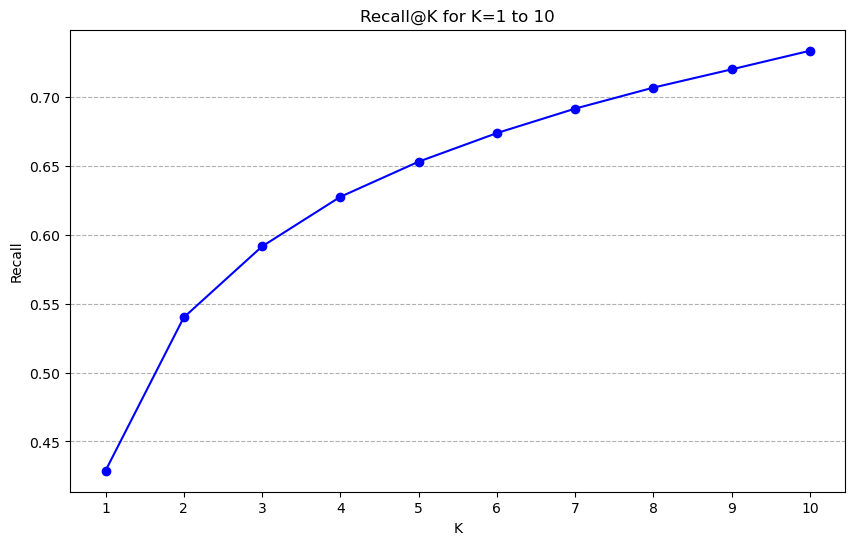

In [8]:
import matplotlib.pyplot as plt

ks = list(recall_results.keys())
recalls = list(recall_results.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ks, recalls, marker='o', linestyle='-', color='b')
plt.title('Recall@K for K=1 to 10')
plt.xlabel('K')
plt.ylabel('Recall')
plt.xticks(ks)
plt.grid(axis='y', linestyle='--')

plt.show()

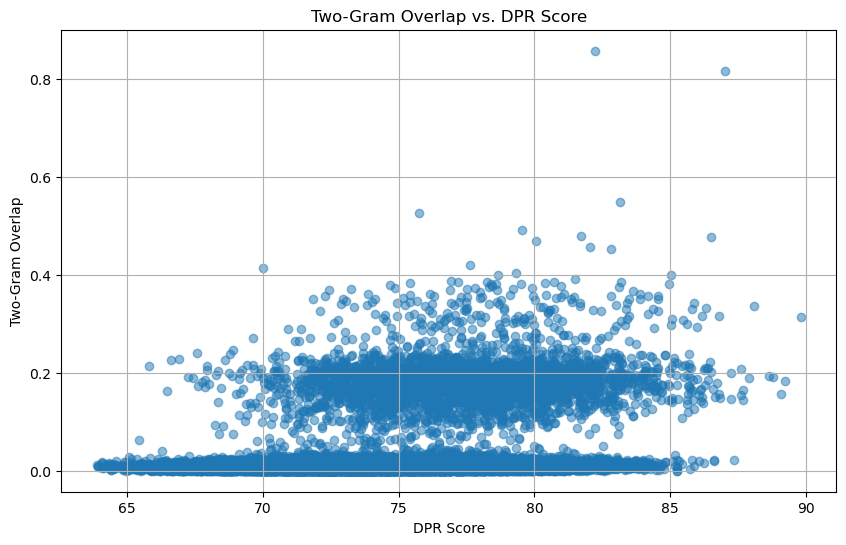

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(dpr_scores, two_gram_overlaps, alpha=0.5)
plt.title('Two-Gram Overlap vs. DPR Score')
plt.xlabel('DPR Score')
plt.ylabel('Two-Gram Overlap')
plt.grid(True)
plt.show()